-------------
### ライブラリのインポート

In [41]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# タイピングのサポート
from typing import Optional

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

--------------
### 辞書作成

実験設定

In [42]:
TARGET = "BCR"
SAMPLE_SIZE = 10000

if TARGET == "GMV":
    X_LIM_VAR = 30000
    X_LIM_REDUC = 30
if TARGET == "BCR":
    X_LIM_VAR = 0.0003
    X_LIM_REDUC = 30

optimal_color = "#6b1314"
proportional_color = "#b87a76"
cuped_color = "#a9a9a9"
coss_color = "#a9a9a9"

各ファイルからコピペ

In [43]:
var_random_train = 2.2378598307100002e-05
var_random_test = 2.2339442044400003e-05

var_sep_dict_train = {
    "Kmeans": {
        "Proportional": 2.0116403518428847e-05,
        "Post": 2.0368106552168922e-05,
        "Optimal": 2.0173874111217573e-05,
    },
    "Lasso-Kmeans": {
        "Proportional": 1.9590815609865592e-05,
        "Post": 1.9222128257966015e-05,
        "Optimal": 1.9360890318315102e-05,
    },
    "SFS-Kmeans-F": {
        "Proportional": 2.1110868612677156e-05,
        "Post": 2.13793049868456e-05,
        "Optimal": 2.1138311441264525e-05,
    },
    "SFS-Kmeans-T": {
        "Proportional": 1.911983494409004e-05,
        "Post": 1.913928008539088e-05,
        "Optimal": 1.9282209567432323e-05,
    },
}
var_sep_dict_test = {
    "Kmeans": {
        "Proportional": 2.0082189143105084e-05,
        "Post": 2.0787227046272794e-05,
        "Optimal": 1.9924247551387674e-05,
    },
    "Lasso-Kmeans": {
        "Proportional": 2.026673214625056e-05,
        "Post": 1.9812732446050073e-05,
        "Optimal": 1.9826770881595428e-05,
    },
    "SFS-Kmeans-F": {
        "Proportional": 2.1713519154936407e-05,
        "Post": 2.1087342400025928e-05,
        "Optimal": 2.1588891503458367e-05,
    },
    "SFS-Kmeans-T": {
        "Proportional": 1.978073110597533e-05,
        "Post": 1.9012122984640223e-05,
        "Optimal": 1.892489654296025e-05,
    },
}

var_once_dict_train = {
    "Proportional": 1.9109380937382403e-05,
    "Post": 1.8882071068643337e-05,
    "Optimal": 1.911296797724747e-05,
}
var_once_dict_test = {
    "Proportional": 1.9123519419536045e-05,
    "Post": 1.9225424097802513e-05,
    "Optimal": 1.9159263059857247e-05,
}

var_cuped_train = 1.897115744869332e-05
var_cuped_test = 1.911270538693194e-05

var_coss_train = 2.036832599640001e-05
var_coss_test = 2.0924232179900006e-05


分散削減率の計算

In [44]:
reduc_sep_dict_train = {}
reduc_sep_dict_test = {}
for method, d in var_sep_dict_train.items():
    reduc_sep_dict_train[method] = {}
    for allo, var in d.items():
        reduc_sep_dict_train[method][allo] = (1 - var / var_random_train) * 100
for method, d in var_sep_dict_test.items():
    reduc_sep_dict_test[method] = {}
    for allo, var in d.items():
        reduc_sep_dict_test[method][allo] = (1 - var / var_random_test) * 100

reduc_once_dict_train = {}
reduc_once_dict_test = {}
for allo, var in var_once_dict_train.items():
    reduc_once_dict_train[allo] = (1 - var / var_random_train) * 100
for allo, var in var_once_dict_test.items():
    reduc_once_dict_test[allo] = (1 - var / var_random_test) * 100

reduc_cuped_train = (1 - var_cuped_train / var_random_train) * 100
reduc_cuped_test = (1 - var_cuped_test / var_random_test) * 100

reduc_coss_train = (1 - var_coss_train / var_random_train) * 100
reduc_coss_test = (1 - var_coss_test / var_random_test) * 100

In [45]:
def make_var_dict(
    var_random: float,
    var_cuped: float,
    var_coss: float,
    var_sep_dict: dict[str, dict[str, float]],
    var_once_dict: dict[str, float],
) -> dict:
    var_dict = {"Random": var_random, "CUPED": var_cuped, "COSS": var_coss}
    for method, _ in var_sep_dict.items():
        var_dict[method] = {
            "Optimal": var_sep_dict[method]["Optimal"],
            "Proportional": var_sep_dict[method]["Proportional"],
        }
    var_dict["SFS-Kmeans-Var"] = {
        "Optimal": var_once_dict["Optimal"],
        "Proportional": var_once_dict["Proportional"],
    }

    return var_dict


def make_reduc_dict(
    reduc_cuped: float,
    reduc_coss: float,
    reduc_sep_dict: dict[str, dict[str, float]],
    reduc_once_dict: dict[str, float],
) -> dict:
    reduc_dict = {"CUPED": reduc_cuped, "COSS": reduc_coss}
    for method, _ in reduc_sep_dict.items():
        reduc_dict[method] = {
            "Optimal": reduc_sep_dict[method]["Optimal"],
            "Proportional": reduc_sep_dict[method]["Proportional"],
        }
    reduc_dict["SFS-Kmeans-Var"] = {
        "Optimal": reduc_once_dict["Optimal"],
        "Proportional": reduc_once_dict["Proportional"],
    }

    return reduc_dict

In [46]:
var_dict_train = make_var_dict(
    var_random=var_random_train,
    var_cuped=var_cuped_train,
    var_coss=var_coss_train,
    var_sep_dict=var_sep_dict_train,
    var_once_dict=var_once_dict_train,
)
var_dict_test = make_var_dict(
    var_random=var_random_test,
    var_cuped=var_cuped_test,
    var_coss=var_coss_train,
    var_sep_dict=var_sep_dict_test,
    var_once_dict=var_once_dict_test,
)

reduc_dict_train = make_reduc_dict(
    reduc_cuped=reduc_cuped_train,
    reduc_coss=reduc_coss_train,
    reduc_sep_dict=reduc_sep_dict_train,
    reduc_once_dict=reduc_once_dict_train,
)
reduc_dict_test = make_reduc_dict(
    reduc_cuped=reduc_cuped_test,
    reduc_coss=reduc_coss_test,
    reduc_sep_dict=reduc_sep_dict_test,
    reduc_once_dict=reduc_once_dict_test,
)

-----------
### 可視化

削減率

訓練データの結果


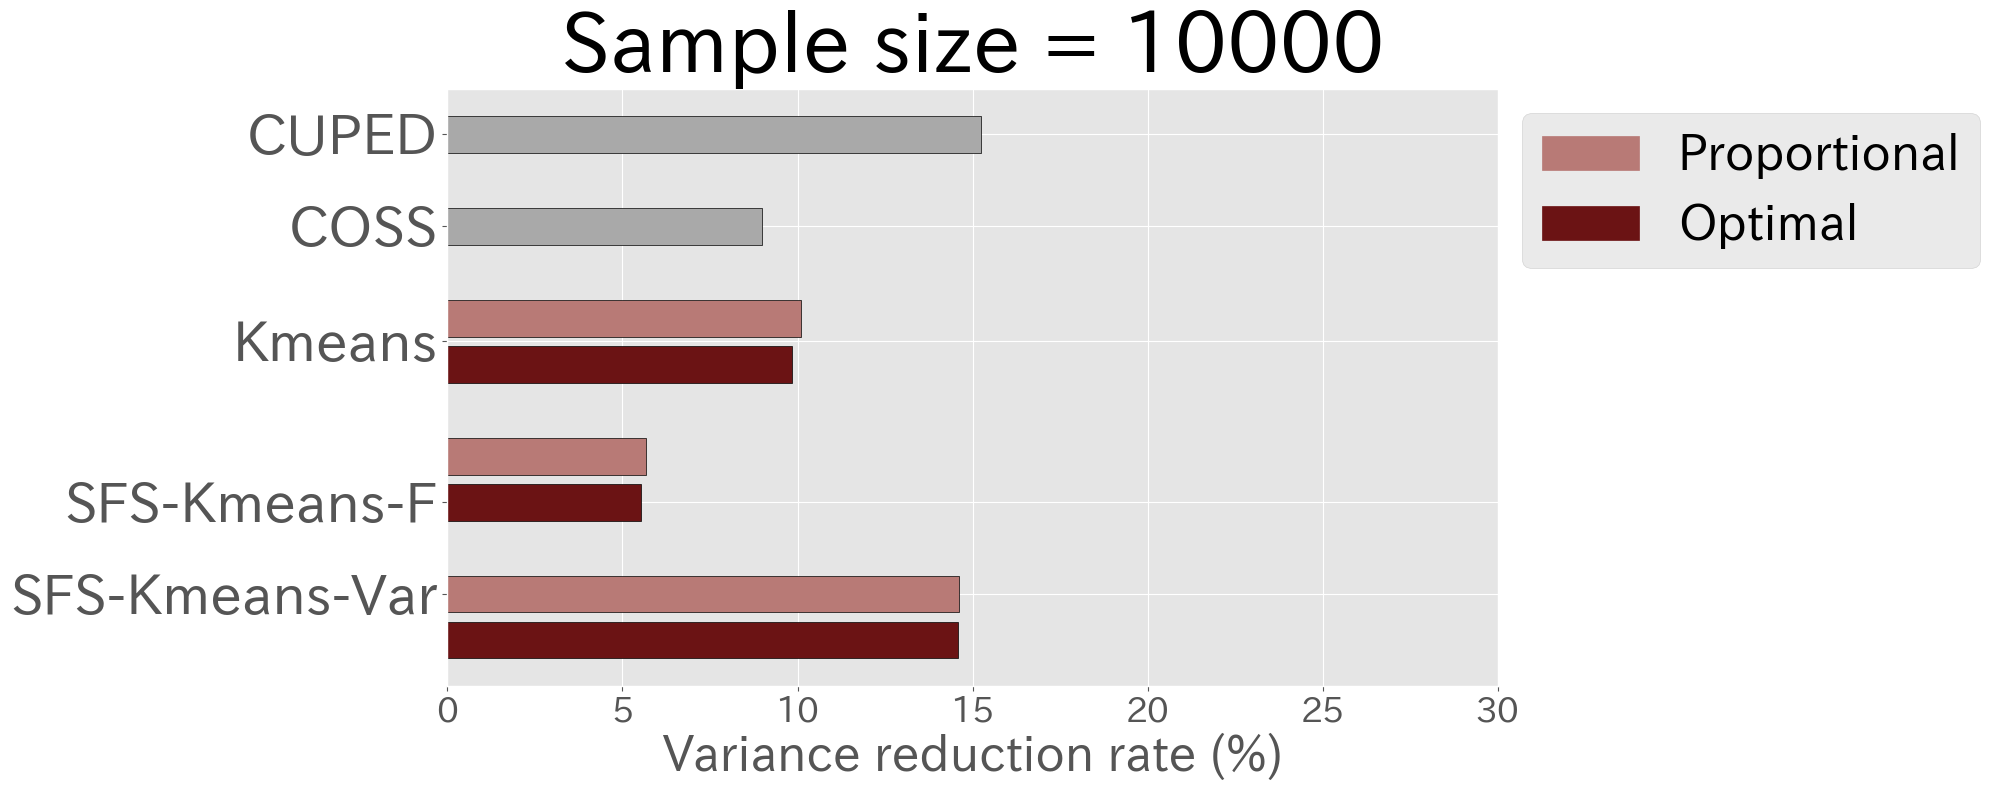

テストデータの結果


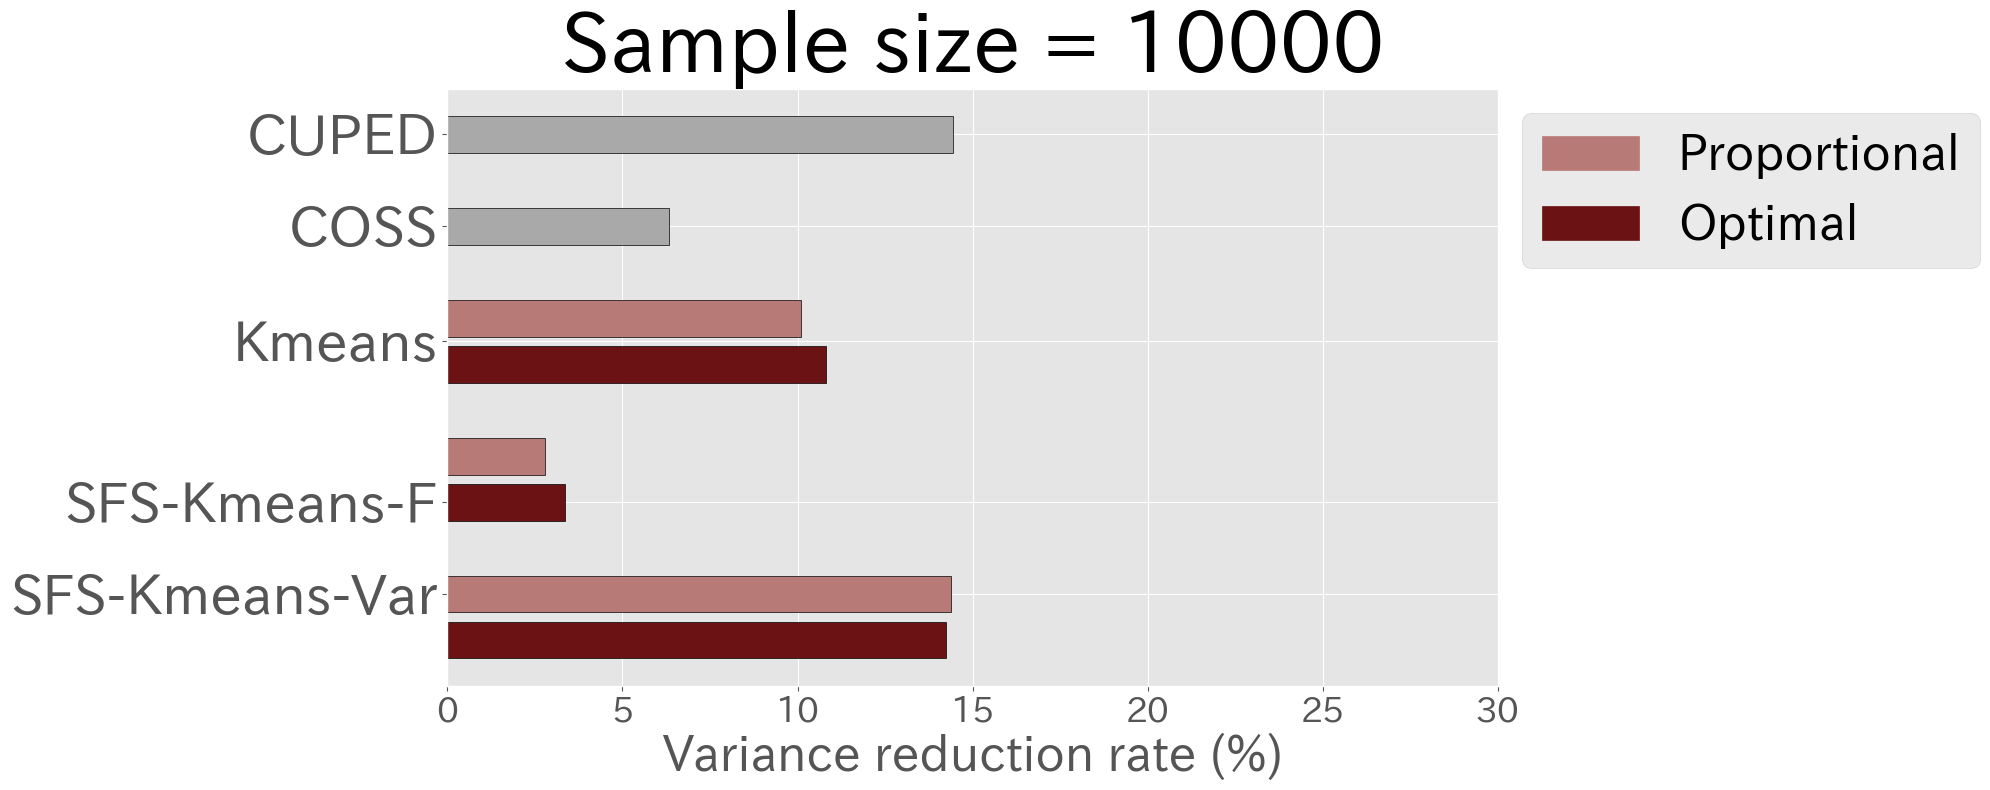

In [47]:
for reduc_dict in [reduc_dict_train, reduc_dict_test]:
    if reduc_dict == reduc_dict_train:
        print("訓練データの結果")
    if reduc_dict == reduc_dict_test:
        print("テストデータの結果")

    # グラフ用データを準備
    labels = [
        "SFS-Kmeans-Var",
        "SFS-Kmeans-F",
        "Kmeans",
        "COSS",
        "CUPED",
    ]
    values = (
        list(reduc_dict["SFS-Kmeans-Var"].values())
        + [0]
        + list(reduc_dict["SFS-Kmeans-F"].values())
        + [0]
        + list(reduc_dict["Kmeans"].values())
        + [0]
        + [reduc_dict["COSS"]]
        + [0]
        + [reduc_dict["CUPED"]]
    )

    # 各グループに色を割り当て、間隔には透明な色を使用
    colors = (
        [optimal_color, proportional_color]
        + ["#FFFFFF00"]
        + [optimal_color, proportional_color]
        + ["#FFFFFF00"]
        + [optimal_color, proportional_color]
        + ["#FFFFFF00"]
        + [coss_color]
        + ["#FFFFFF00"]
        + [cuped_color]
    )

    # 各ラベルが3つの棒の真ん中に配置されるように位置を調整
    y_positions = [1, 3, 6.5, 9, 11]

    # グラフを描画
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.barh(range(len(values)), values, color=colors, edgecolor="black")

    # 凡例の追加
    legend_labels = ["Proportional", "Optimal"]
    # 色のリスト
    legend_colors = [proportional_color, optimal_color]
    # 各ラベルに対してハンドルを作成
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in legend_colors]
    ax.legend(
        handles, legend_labels, fontsize=35, loc="upper left", bbox_to_anchor=(1, 1)
    )

    # y軸の目盛りとラベルを設定
    ax.set_yticks(y_positions)
    ax.tick_params(axis="x", labelsize=25)
    ax.set_yticklabels(labels, fontsize=40)
    ax.set_xlabel("Variance reduction rate (%)", fontsize=35)
    ax.set_title(f"Sample size = {SAMPLE_SIZE}", fontsize=60)
    ax.set_xlim(0, X_LIM_REDUC)
    plt.tight_layout()
    plt.show()

Target :  BCR
sample size : 10000
訓練データの結果


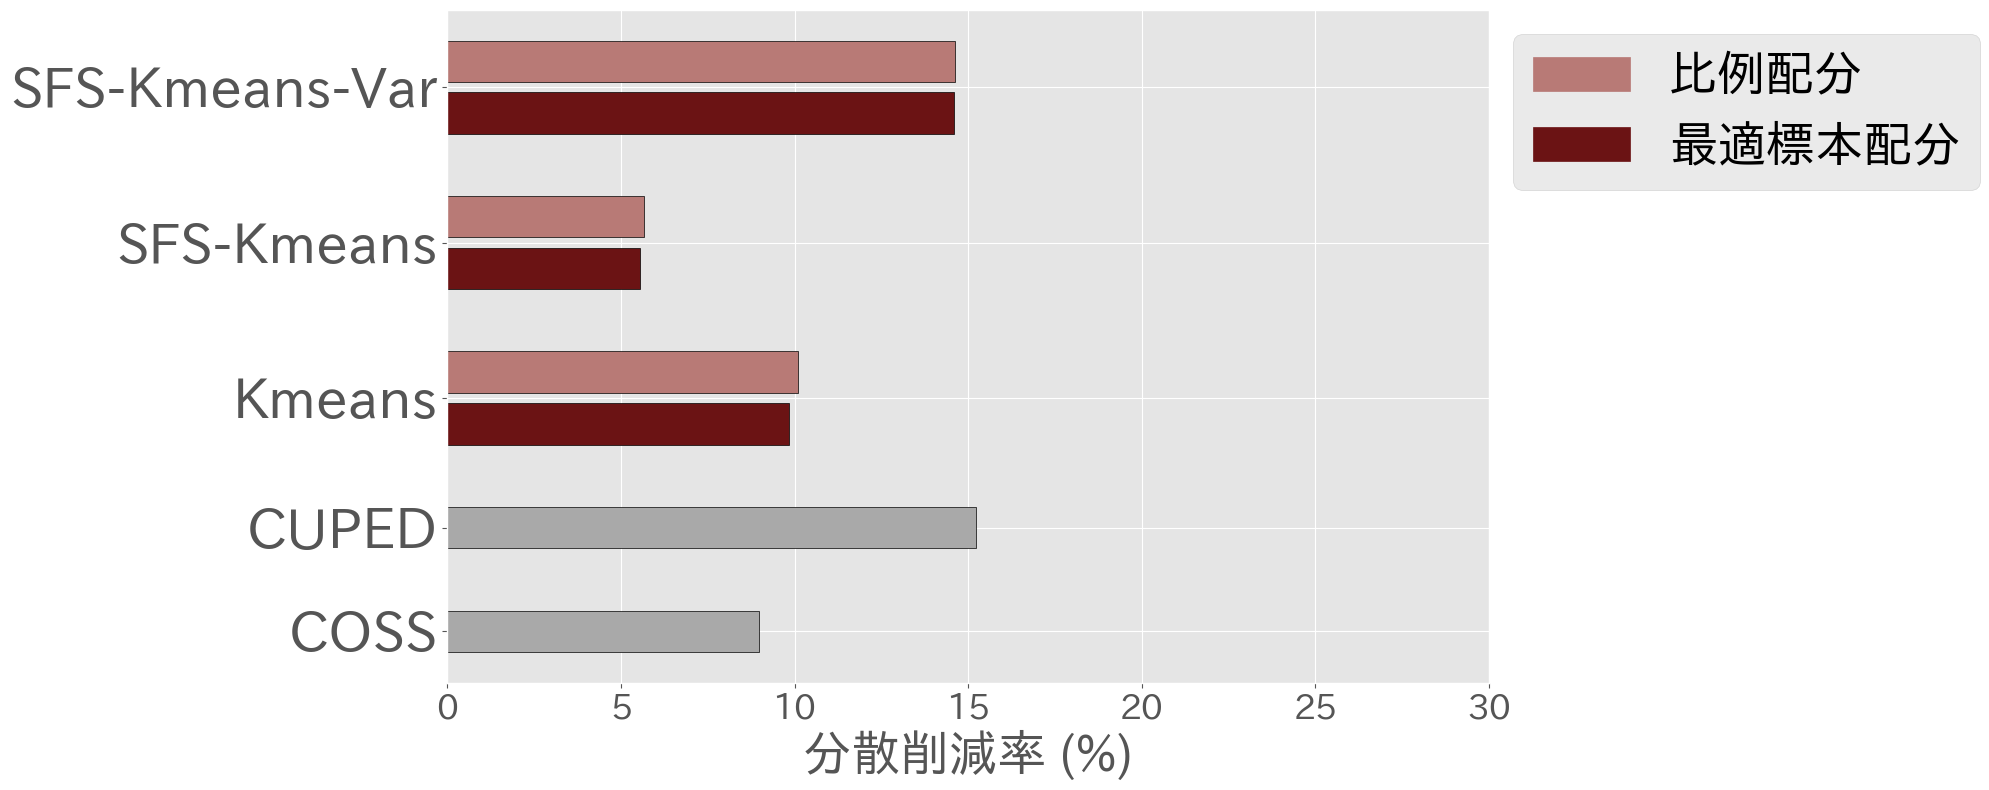

テストデータの結果


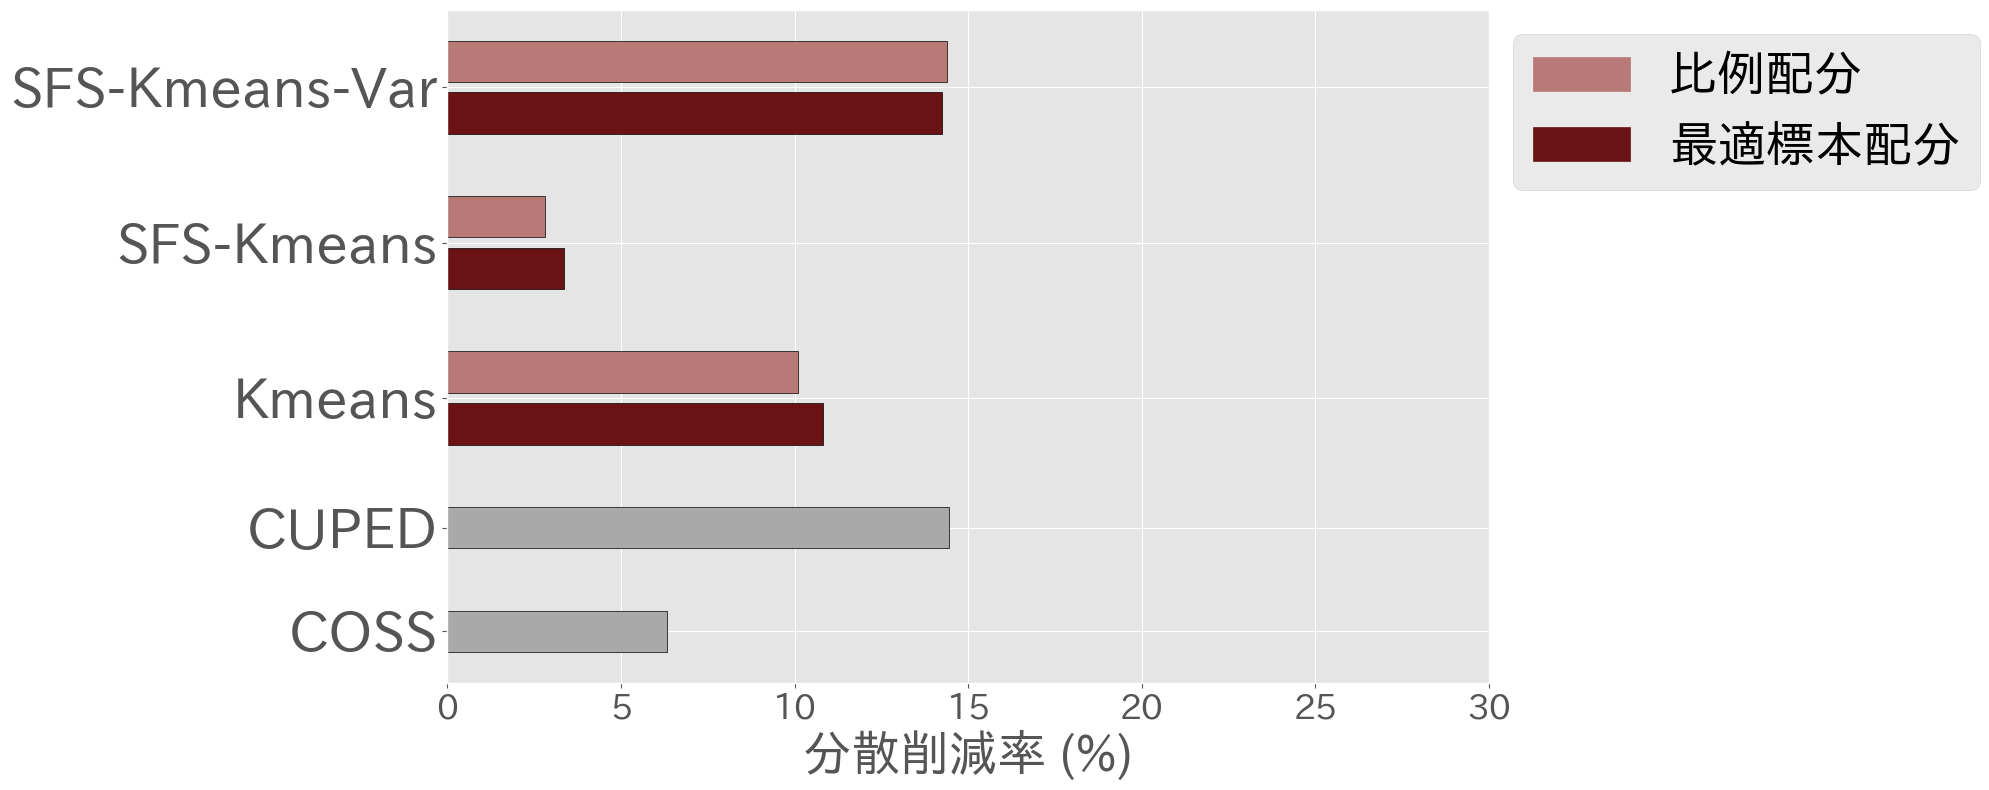

In [48]:
print("Target : ", TARGET)
print("sample size :", SAMPLE_SIZE)

for reduc_dict in [reduc_dict_train, reduc_dict_test]:
    if reduc_dict == reduc_dict_train:
        print("訓練データの結果")
    if reduc_dict == reduc_dict_test:
        print("テストデータの結果")

    # グラフ用データを準備
    labels = [
        "COSS",
        "CUPED",
        "Kmeans",
        "SFS-Kmeans",
        "SFS-Kmeans-Var",
    ]
    values = (
        [reduc_dict["COSS"]]
        + [0]
        + [reduc_dict["CUPED"]]
        + [0]
        + list(reduc_dict["Kmeans"].values())
        + [0]
        + list(reduc_dict["SFS-Kmeans-F"].values())
        + [0]
        + list(reduc_dict["SFS-Kmeans-Var"].values())
    )

    # 各グループに色を割り当て、間隔には透明な色を使用
    colors = (
        [coss_color]
        + ["#FFFFFF00"]
        + [cuped_color]
        + ["#FFFFFF00"]
        + [optimal_color, proportional_color]
        + ["#FFFFFF00"]
        + [optimal_color, proportional_color]
        + ["#FFFFFF00"]
        + [optimal_color, proportional_color]
    )

    # 各ラベルが3つの棒の真ん中に配置されるように位置を調整
    y_positions = [0, 2, 4.5, 7.5, 10.5]

    # グラフを描画
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.barh(range(len(values)), values, color=colors, edgecolor="black")

    # 凡例の追加
    legend_labels = ["比例配分", "最適標本配分"]
    # 色のリスト
    legend_colors = [proportional_color, optimal_color]
    # 各ラベルに対してハンドルを作成
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in legend_colors]
    ax.legend(
        handles, legend_labels, fontsize=35, loc="upper left", bbox_to_anchor=(1, 1)
    )

    # y軸の目盛りとラベルを設定
    ax.set_yticks(y_positions)
    ax.tick_params(axis="x", labelsize=25)
    ax.set_yticklabels(labels, fontsize=40)
    ax.set_xlabel("分散削減率 (%)", fontsize=35)
    ax.set_xlim(0, X_LIM_REDUC)
    plt.tight_layout()
    plt.show()

### 箱ひげ図